# The effects of lowering image resolution

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
%matplotlib inline

from IPython.display import display

PATH = os.path.abspath('../..')

# Plotting function

In [3]:
mad = lambda x: np.median(np.abs(x - np.median(x)))

def nmad(z, const=1.4826):
    """Returns the Gaussian sigma according to MAD"""
    return const*mad(z)

def rmse(z):
    """Returns the root mean squared error"""
    return np.sqrt(np.mean(z**2))

In [4]:
def plot_scatter(y_test, p_test, sz, ax, which_scatter, plot_style='scatter'):
    """Plot metallicity scatter for given resolution (image size, sz)"""
    
    bmin, bmax, step = 8.2, 9.3, 0.1

    y_bins = np.arange(bmin, bmax, step)
    num_in_bins = np.sum([(y_test > y - step/2) & (y_test < y + step/2) for y in y_bins], axis=1)

    if which_scatter == 'RMSE':
        rmse_bins = np.array([rmse((p_test - y_test)[(y_test > y - step/2) & (y_test < y + step/2)]) for y in y_bins])
        rmse_error = rmse(p_test - y_test)
        
        if plot_style == 'scatter':
            ax.scatter(y_bins, rmse_bins, marker='o', c='C0', s=num_in_bins/30, label=f'{sz:>3d} RMSE = {rmse_error:.4f}')
        elif plot_style == 'line':
            ax.plot(y_bins, rmse_bins, c=plt.cm.GnBu(np.log2(sz)/7 + 0.1), lw=3, label=f'{sz:>3d} RMSE = {rmse_error:.4f}')

    elif which_scatter == 'NMAD':
        nmad_bins = np.array([nmad(((p_test - y_test)[(y_test > y - step/2) & (y_test < y + step/2)])) for y in y_bins])
        nmad_error = nmad(p_test - y_test)
        # weighted nmad error
        #nmad_error = np.average(nmad_bins, weights=num_in_bins)
        if plot_style == 'scatter':
            ax.scatter(y_bins, nmad_bins, marker='o', c='C1', s=num_in_bins/30, label=f'{sz:>3d} NMAD = {nmad_error:.4f}')
        elif plot_style == 'line':
            ax.plot(y_bins, nmad_bins, c=plt.cm.autumn(np.log2(sz)/7 + 0.1), lw=3, label=f'{sz:>3d} NMAD = {nmad_error:.4f}')
    

# Testing the function

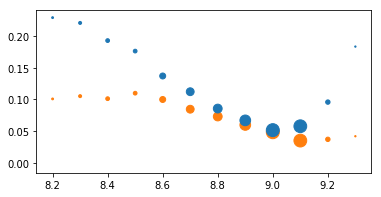

In [5]:
# get predictions
sz = 64
preds = pd.read_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv', index_col=0)
preds.head()


# make plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

plot_scatter(preds.oh_p50, preds.prediction, sz, ax, which_scatter='NMAD')
plot_scatter(preds.oh_p50, preds.prediction, sz, ax, which_scatter='RMSE')

# All resolutions

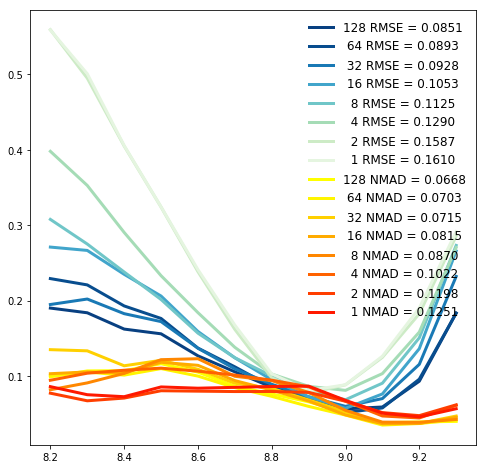

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for which_scatter in ['RMSE', 'NMAD']:
    sz = 128
    preds = pd.read_csv(f'{PATH}/catalogs/predictions-oh_p50.csv', index_col=0)
    plot_scatter(preds.oh_p50, preds.prediction, sz, ax, which_scatter=which_scatter, plot_style='line')
    for sz in [64, 32, 16, 8, 4, 2, 1]:
        preds = pd.read_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv', index_col=0)
        plot_scatter(preds.oh_p50, preds.prediction, sz, ax, which_scatter=which_scatter, plot_style='line')

ax.legend(fontsize=12, framealpha=0.0, frameon=False, loc='upper right')


# Scatter scaling with resolution

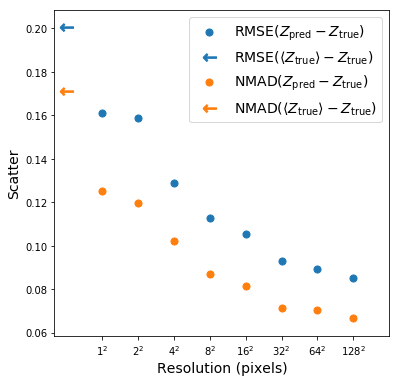

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))


# compute random scatter about median in total sample
intrinsic_rmse = rmse(preds.oh_p50 - np.mean(preds.oh_p50))
intrinsic_nmad = nmad(preds.oh_p50 - np.mean(preds.oh_p50))

sizes = [128, 64, 32, 16, 8, 4, 2, 1]
rmses = []
nmads = []
for sz in sizes:
    preds = pd.read_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv', index_col=0)
    
    rmses.append(rmse(preds.prediction - preds.oh_p50))
    nmads.append(nmad(preds.prediction - preds.oh_p50))
    
ax.scatter(sizes, rmses, c='C0', s=50, label=r'RMSE($Z_{\rm pred} - Z_{\rm true}$)')
ax.scatter(0.5, intrinsic_rmse, marker='$\u2190$', s=200, c='C0', label=r'RMSE($\langle Z_{\rm true}\rangle - Z_{\rm true}$)')
ax.scatter(sizes, nmads, c='C1', s=50, label=r'NMAD($Z_{\rm pred} - Z_{\rm true}$)')
ax.scatter(0.5, intrinsic_nmad, marker='$\u2190$', s=200, c='C1', label=r'NMAD($\langle Z_{\rm true}\rangle - Z_{\rm true}$)')

ax.set_xscale('log')
plt.minorticks_off()
ax.set_xticks(list(reversed(sizes)), minor=False)
ax.set_xticklabels(list(reversed([str(s) + r'$^2$' for s in sizes])))

ax.set_xlim(0.4, 256)
ax.set_xlabel('Resolution (pixels)', fontsize=14)
ax.set_ylabel('Scatter', fontsize=14)

ax.legend(fontsize=14);

fig.savefig(f'{PATH}/results/04-resolution.pdf')

The same thing, but on a log-log plot

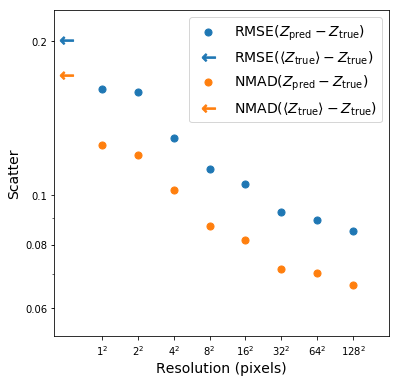

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sizes = [128, 64, 32, 16, 8, 4, 2, 1]
rmses = []
nmads = []
for sz in sizes:
    preds = pd.read_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv', index_col=0)
    
    rmses.append(rmse(preds.prediction - preds.oh_p50))
    nmads.append(nmad(preds.prediction - preds.oh_p50))
    
# compute random scatter about median in total sample
intrinsic_rmse = rmse(preds.oh_p50 - np.mean(preds.oh_p50))
intrinsic_nmad = nmad(preds.oh_p50 - np.mean(preds.oh_p50))

ax.scatter(sizes, rmses, c='C0', s=50, label=r'RMSE($Z_{\rm pred} - Z_{\rm true}$)')
ax.scatter(0.5, intrinsic_rmse, marker='$\u2190$', s=200, c='C0', label=r'RMSE($\langle Z_{\rm true}\rangle - Z_{\rm true}$)')
ax.scatter(sizes, nmads, c='C1', s=50, label=r'NMAD($Z_{\rm pred} - Z_{\rm true}$)')
ax.scatter(0.5, intrinsic_nmad, marker='$\u2190$', s=200, c='C1', label=r'NMAD($\langle Z_{\rm true}\rangle - Z_{\rm true}$)')


ax.set_xscale('log')
ax.minorticks_off()
ax.set_xticks(list(reversed(sizes)), minor=False)
ax.set_xticklabels(list(reversed([str(s) + r'$^2$' for s in sizes])))

ax.set_yscale('log')
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_yticks([.06, .08, 0.1, 0.2])
ax.set_yticklabels([.06, .08, 0.1, 0.2])

ax.set_xlim(0.4, 256)
ax.set_xlabel('Resolution (pixels)', fontsize=14)
ax.set_ylim(0.053, 0.23)
ax.set_ylabel('Scatter', fontsize=14)

ax.legend(fontsize=14);

#fig.savefig(f'{PATH}/results/03-resolution.pdf')

# Ratio of two scatters

0.8538608065543263


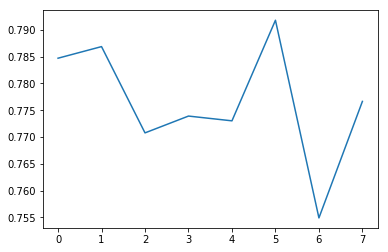

In [9]:
plt.plot(np.array(nmads) / np.array(rmses))

print(intrinsic_nmad / intrinsic_rmse)

# Including a random forest

In [10]:
import sklearn
import sklearn.ensemble
import sklearn_pandas

In [11]:
df = pd.read_csv(f'{PATH}/catalogs/SDSSspecgalsDR14_boada.csv')

# cut columns
columns_of_interest = ['objID', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'oh_p50']
df = df.loc[:, columns_of_interest]

df.set_index('objID', inplace=True)
df.describe()

,modelMag_g,modelMag_r,modelMag_i,oh_p50
count,142186.000000,142186.000000,142186.000000,142186.000000
mean,17.671626,17.106933,16.765659,8.906503
std,0.677756,0.671206,0.684535,0.198560
min,13.351350,12.018020,11.982250,7.851740
25%,17.339060,16.791332,16.446108,8.808777
50%,17.832575,17.291490,16.944820,8.955610
75%,18.154280,17.602540,17.256935,9.053747
max,24.378170,19.187200,24.817750,9.469999


## Use same test-train split as CNN

In [12]:
df_test = df.loc[preds.index]
df_test.describe()

,modelMag_g,modelMag_r,modelMag_i,oh_p50
count,20467.000000,20467.000000,20467.000000,20467.000000
mean,17.665191,17.100300,16.758925,8.905743
std,0.684137,0.678920,0.690011,0.200184
min,13.886560,12.962520,12.395470,7.896335
25%,17.325245,16.780315,16.438615,8.808639
50%,17.832370,17.287650,16.940770,8.955670
75%,18.153095,17.605120,17.257805,9.054213
max,22.461750,18.397070,24.362130,9.465558


In [13]:
df_train = df.drop(preds.index)
df_train.describe()

,modelMag_g,modelMag_r,modelMag_i,oh_p50
count,121719.000000,121719.000000,121719.000000,121719.000000
mean,17.672708,17.108049,16.766791,8.906631
std,0.676674,0.669897,0.683606,0.198286
min,13.351350,12.018020,11.982250,7.851740
25%,17.341985,16.793165,16.447555,8.808808
50%,17.832620,17.292030,16.945600,8.955603
75%,18.154470,17.602210,17.256735,9.053669
max,24.378170,19.187200,24.817750,9.469999


In [14]:
X = df_train[['modelMag_g', 'modelMag_r', 'modelMag_i']]
y = df_train['oh_p50']

In [15]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=256)

## Train RF

In [25]:
%%time
reg = sklearn.ensemble.RandomForestRegressor(criterion='mse', random_state=256)

reg.fit(X_train, y_train)

CPU times: user 3.67 s, sys: 28 ms, total: 3.7 s
Wall time: 3.69 s


## Train RF using Viviana (2016) method

In [26]:
%%time
reg_V16 = sklearn.ensemble.RandomForestRegressor(bootstrap=True,
           criterion='mse', max_depth=None, max_features='auto', min_samples_leaf=8,
           min_samples_split=2, n_estimators=40, n_jobs=1, oob_score=False,
           random_state=256, verbose=0)

reg_V16.fit(X_train, y_train)

CPU times: user 10.6 s, sys: 20 ms, total: 10.6 s
Wall time: 10.6 s


## Compute validation metrics

In [27]:
p = reg.predict(X_val)

In [30]:
print('RMSE = {:.4f}'.format(rmse(p - y_val)))
print('NMAD = {:.4f}'.format(nmad(p - y_val)))

RMSE = 0.1354
NMAD = 0.1165


In [31]:
p_V16 = reg_V16.predict(X_val)

In [32]:
print('RMSE = {:.4f}'.format(rmse(p_V16 - y_val)))
print('NMAD = {:.4f}'.format(nmad(p_V16 - y_val)))

RMSE = 0.1269
NMAD = 0.1078


## Test metrics

In [33]:
X_test = df_test[['modelMag_g', 'modelMag_r', 'modelMag_i']]
y_test = df_test['oh_p50']

In [34]:
p_test = reg.predict(X_test)

In [35]:
rmse_RF = rmse(p_test - y_test)
nmad_RF = nmad(p_test - y_test)
print(f'RMSE = {rmse_RF:.4f}')
print(f'NMAD = {nmad_RF:.4f}')

RMSE = 0.1380
NMAD = 0.1162


In [36]:
p_test_V = reg_V16.predict(X_test)

In [37]:
rmse_RF_V16 = rmse(p_test_V - y_test)
nmad_RF_V16 = nmad(p_test_V - y_test)
print(f'RMSE = {rmse_RF_V16:.4f}')
print(f'NMAD = {nmad_RF_V16:.4f}')

RMSE = 0.1296
NMAD = 0.1059


# Plot including RF

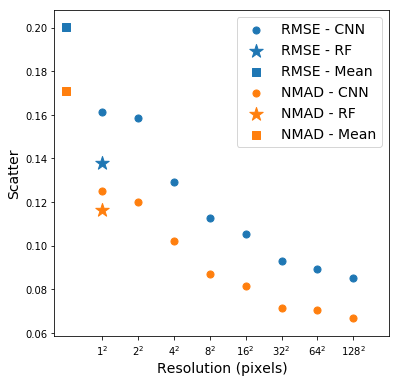

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))


# compute random scatter about median in total sample
intrinsic_rmse = rmse(preds.oh_p50 - np.mean(preds.oh_p50))
intrinsic_nmad = nmad(preds.oh_p50 - np.mean(preds.oh_p50))

sizes = [128, 64, 32, 16, 8, 4, 2, 1]
rmses = []
nmads = []
for sz in sizes:
    preds = pd.read_csv(f'{PATH}/catalogs/predictions_{sz}-oh_p50.csv', index_col=0)
    
    rmses.append(rmse(preds.prediction - preds.oh_p50))
    nmads.append(nmad(preds.prediction - preds.oh_p50))
    
ax.scatter(sizes, rmses, c='C0', s=50, label=r'RMSE - CNN')
ax.scatter(1, rmse_RF, c='C0', s=200, marker='*', label=r'RMSE - RF')
ax.scatter(0.5, intrinsic_rmse, marker='s', s=50, c='C0', label=r'RMSE - Mean')
ax.scatter(sizes, nmads, c='C1', s=50, label=r'NMAD - CNN')
ax.scatter(1, nmad_RF, c='C1', s=200, marker='*', label=r'NMAD - RF')
ax.scatter(0.5, intrinsic_nmad, marker='s', s=50, c='C1', label=r'NMAD - Mean')

ax.set_xscale('log')
plt.minorticks_off()
ax.set_xticks(list(reversed(sizes)), minor=False)
ax.set_xticklabels(list(reversed([str(s) + r'$^2$' for s in sizes])))

ax.set_xlim(0.4, 256)
ax.set_xlabel('Resolution (pixels)', fontsize=14)
ax.set_ylabel('Scatter', fontsize=14)

ax.legend(fontsize=14);

fig.savefig(f'{PATH}/results/04-resolution.pdf')